# CNN-LSTM Hybrid Migraine Prediction

This notebook demonstrates migraine prediction using a hybrid CNN-LSTM model. The CNN layers act as feature extractors on daily data, and the LSTM models the temporal sequence of these features. The workflow follows the structure of the other notebooks.

## 1. Import Required Libraries
Import libraries for data handling, model building, and visualization.

In [40]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, GRU, Dense, Dropout, Flatten, TimeDistributed, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## 2. Prepare the Dataset
Load and inspect the dataset to be used for CNN-LSTM modeling.

In [41]:
from prediction.data_processing import merge_migraine_and_weather_data, process_combined_data

# Merge and process data
merge_migraine_and_weather_data()
data = process_combined_data()

data.drop(columns=['Notes'], inplace=True, errors='ignore')  # Drop 'Notes' column if it exists
data.head()

,Date,Time,Pain Level,Medication,Dosage,Triggers,Location,Latitude_x,Longitude_x,Timezone,...,Physical Activity_0.0,Physical Activity_1.0,tdiff,tavg_lag1,tavg_lag2,humid.*tavg,pres_change_lag1,pres_change_lag2,Pain_Level_Log,Pain_Level_Binary
0,2023-01-01,0,0.0,NaN,NaN,NaN,"Carlsbad, California, USA",33.1581,-117.3506,America/Los_Angeles,...,False,False,2.8,NaN,NaN,1147.928,NaN,NaN,0.0,0
1,2023-01-02,0,0.0,NaN,NaN,NaN,"Carlsbad, California, USA",33.1581,-117.3506,America/Los_Angeles,...,False,False,7.2,14.2,NaN,878.712,NaN,NaN,0.0,0
2,2023-01-03,0,0.0,NaN,NaN,NaN,"Carlsbad, California, USA",33.1581,-117.3506,America/Los_Angeles,...,False,False,4.4,11.4,14.2,1116.160,6.4,NaN,0.0,0
3,2023-01-04,0,0.0,NaN,NaN,NaN,"Carlsbad, California, USA",33.1581,-117.3506,America/Los_Angeles,...,False,False,3.8,12.8,11.4,1364.220,2.5,6.4,0.0,0
4,2023-01-05,0,0.0,NaN,NaN,NaN,"Carlsbad, California, USA",33.1581,-117.3506,America/Los_Angeles,...,False,False,6.1,15.9,12.8,1192.464,1.0,2.5,0.0,0


## 3. Preprocess Data for CNN-LSTM
Normalize the data, create sequences, and reshape for CNN-LSTM input.

In [42]:
# Use all data for binary classification (migraine/no migraine)
data = data.dropna(axis=1)

# Select features and binary target
feature_cols = data.drop(columns=[
    'Date', 'date', 'Medication', 'Dosage', 'Triggers', 'Notes', 'Location', 'Timezone',
    'Pain Level', 'Pain_Level_Log',
    'Longitude', 'Latitude', 'Time',
    'Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y',
], errors='ignore').columns

features = data[feature_cols].values
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
target = data['Pain_Level_Binary'].values

# Create CNN-LSTM sequences
def create_cnn_lstm_sequences(features, target, seq_len=7):
    X, y = [], []
    for i in range(len(features) - seq_len):
        X.append(features[i:i+seq_len])
        y.append(target[i+seq_len])
    return np.array(X), np.array(y)

SEQ_LEN = 7
X, y = create_cnn_lstm_sequences(features_scaled, target, SEQ_LEN)

# Reshape for CNN-LSTM: (samples, timesteps, features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'CNN-LSTM input shape: {X_train.shape}')

print(pd.Series(y_train).value_counts())

print(X_train.shape, X_test.shape)

CNN-LSTM input shape: (677, 7, 34)
0    404
1    273
Name: count, dtype: int64
(677, 7, 34) (170, 7, 34)


## 4. Build the CNN-LSTM Model
Define and compile the CNN-LSTM model architecture using Keras.

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2

def create_cnn_lstm_model(input_shape, l2_reg=0.01):
    """
    Builds a CNN-LSTM model for binary classification.
    Args:
        input_shape (tuple): The shape of the input data (time_steps, features).
        l2_reg (float): The L2 regularization factor.
    Returns:
        A compiled Keras model.
    """
    model = Sequential()
    # 1D Convolutional Block
    model.add(Conv1D(
        filters=64, 
        kernel_size=2, 
        activation='relu', 
        input_shape=input_shape,
        kernel_regularizer=l2(l2_reg) 
    ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2)) 
    # LSTM Block
    model.add(LSTM(
        units=100, 
        activation='relu', 
        kernel_regularizer=l2(l2_reg)
    ))
    model.add(Dropout(0.2))
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model

# Example usage for a dataset with 7 time steps and n features
input_shape = (SEQ_LEN, X_train.shape[2])
model = create_cnn_lstm_model(input_shape)
model.summary()

/Users/Aresh/Desktop/Projects/Migraine Navigator/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 6, 64)          │         4,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 100)            │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,517 (275.46 KB)

 Trainable params: 70,517 (275.46 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Train the CNN-LSTM Model
Train the CNN-LSTM model on the prepared data and monitor training progress.

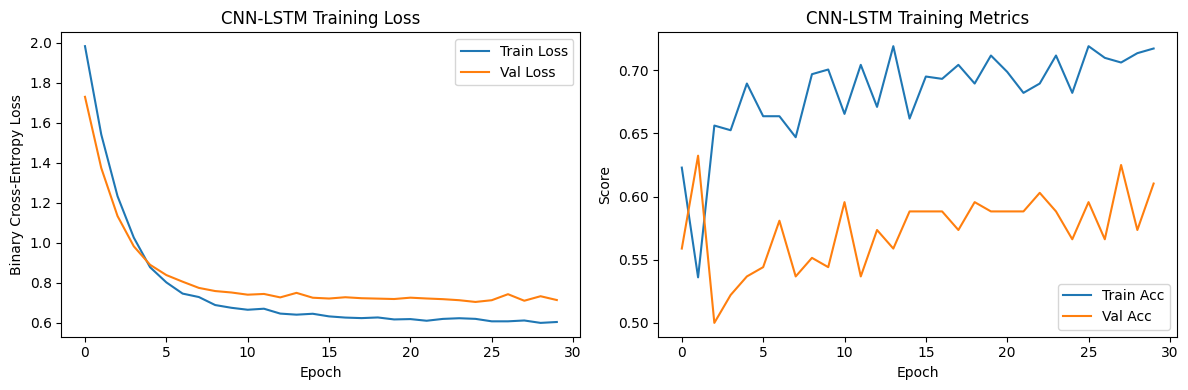

In [44]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights for binary classification
class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0,
    class_weight=class_weights
)

# Plot training history: loss and accuracy/precision/recall
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('CNN-LSTM Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
# Dynamically plot precision and recall if present
for metric in ['precision', 'precision_1', 'val_precision', 'val_precision_1', 'recall', 'recall_1', 'val_recall', 'val_recall_1']:
    if metric in history.history:
        plt.plot(history.history[metric], label=metric)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('CNN-LSTM Training Metrics')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Evaluate Model Performance
Evaluate the trained CNN-LSTM model using regression metrics and visualize the results.

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
CNN-LSTM Binary Classification Accuracy: 0.69
Precision: 0.67
Recall: 0.45
F1 Score: 0.54
ROC AUC: 0.70
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       103
           1       0.67      0.45      0.54        67

    accuracy                           0.69       170
   macro avg       0.69      0.65      0.65       170
weighted avg       0.69      0.69      0.68       170

CNN-LSTM Binary Classification Accuracy: 0.69
Precision: 0.67
Recall: 0.45
F1 Score: 0.54
ROC AUC: 0.70
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       103
           1       0.67      0.45      0.54        67

    accuracy                           0.69       170
   macro avg       0.69      0.65      0.65       170
weighted avg       0.69      0.69      0.68       170



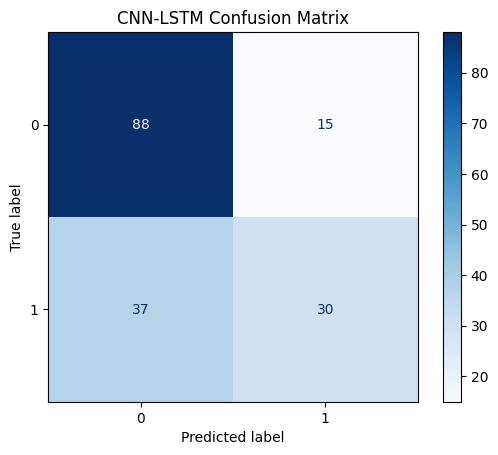

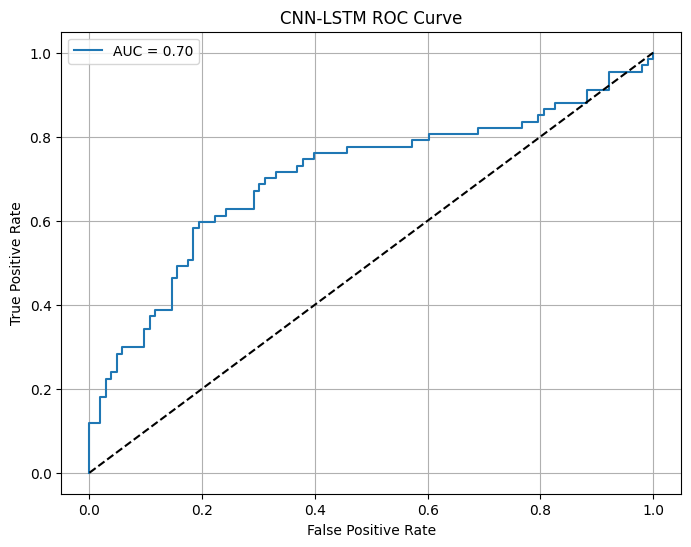

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, classification_report

# Predict probabilities and binary labels
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f'CNN-LSTM Binary Classification Accuracy: {acc:.2f}')
print(f'Precision: {prec:.2f}')
print(f'Recall: {rec:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {auc:.2f}')
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('CNN-LSTM Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN-LSTM ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

## 7. Make Predictions with the CNN-LSTM Model

Use the trained CNN-LSTM model to make predictions on new/unseen data and visualize the results. This section demonstrates how to use the model for inference and interpret the outputs.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
True pain level: 0
Predicted pain level: 0.4037654995918274
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
True pain level: 0
Predicted pain level: 0.4037654995918274
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


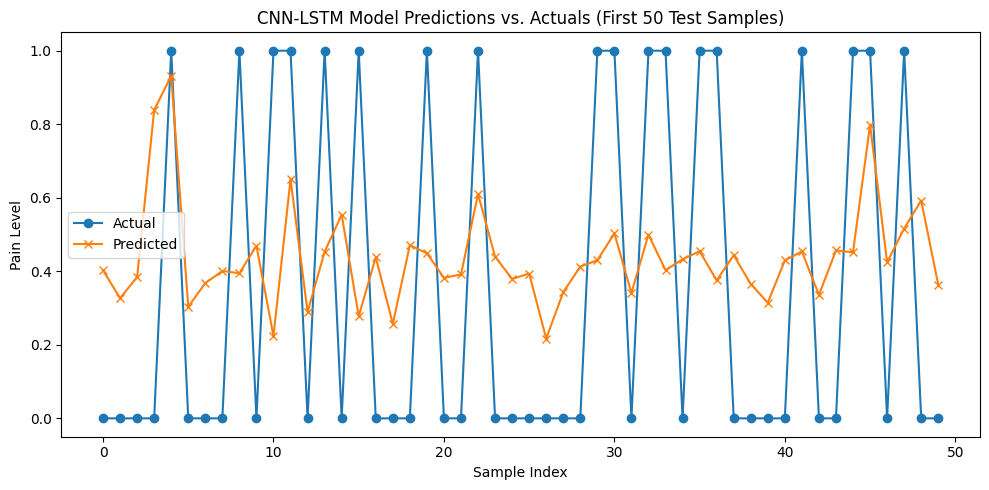

In [46]:
# Example: Predict on a new sample (using the last sequence from the test set)
new_X = X_test[-1:]
new_y_true = y_test[-1]
new_y_pred = model.predict(new_X).flatten()[0]

print(f'True pain level: {new_y_true}')
print(f'Predicted pain level: {new_y_pred}')

# Visualize prediction vs. actual for a batch of test samples
plt.figure(figsize=(10,5))
plt.plot(y_test[:50], label='Actual', marker='o')
plt.plot(model.predict(X_test[:50]).flatten(), label='Predicted', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Pain Level')
plt.title('CNN-LSTM Model Predictions vs. Actuals (First 50 Test Samples)')
plt.legend()
plt.tight_layout()
plt.show()